In [143]:
import sys, nltk, re
import pandas as pd
import numpy as np
import pickle
import time
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import Word
from textstat.textstat import textstat
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import  mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import  SVR
from sklearn.linear_model import LassoCV
from scipy.stats import pearsonr


# 1. Data
这次数据集提供围绕特定主题的英语文章文本数据，可用于针对学生所写的英文作文进行机器自动评分。
由于对于应试教育作文打分有一定规则，因而可以通过机器来学习这样的规则。每个老师对于作文评分
在1至6之间，一篇作文由两位老师打分，之后相加得到作文总分。最后提交为这篇作文总分，作为预测结果。

项目提供txt文件，每列由tab隔开。每行为一个样例
训练集共1200个样本，5个字段，分别为编号，文本，评分1，评分2，作文总分

示例：

1 "Dear Local Newspaper, I believe the ……” 4 4 8

2 "Dear @CAPS1 @CAPS2, I have heard ……” 6 4 10

测试集共550样本，2个字段，分别为编号，文本。

示例：

1 "Dear Local Newspaper, I believe the ……”

2 "Dear @CAPS1 @CAPS2, I have heard ……”

In [57]:
train_path = r'essay_train.txt'
test_path = r'essay_test.txt'
df_train = pd.read_table(train_path,header = None,names=["id", "text", "score1", "score2","score"])
df_test = pd.read_table(test_path,header = None,names=["id", "text"])
features = pd.DataFrame()

# 2 特征提取
## 2.1 Length Features

首先我们先统计字符数、句子数以及平均句子长度。以下不做特殊说明，大家可以把每个函数中的content当作是我们training set中的单个essay!

In [10]:
def length_counts(content):  
    char_count = len(content)
    
    words = nltk.word_tokenize(content.strip())     
    word_count = len(words) 
    
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    sents = sent_detector.tokenize(content.strip())
    sentence_count = len(sents) 

    if sentence_count != 0:
        avg_sentence_len = word_count / sentence_count 
    else:
        avg_sentence_len = 0
        
    return char_count, word_count,sentence_count, avg_sentence_len

In [54]:
len_features = np.array([length_counts(essay) for essay in list(df_train.text)])

In [61]:
features['char_count'],features['word_count'],features['sentence_count'],features['avg_sentence_len']\
                 = len_features[:,0],len_features[:,1],len_features[:,2],len_features[:,3]

## 1.2 Occurrence Features

统计每个essay中的标点、stopwords、错词以及SAT词汇出现的次数。这里SAT词汇来自是将雅思官网5000词汇down下来后，存到了本地了txt文件中，然后通过定义的get_sat_word 函数进行提取。

In [66]:
def get_sat_word(path):
    with open(path, 'r') as f:
        sat = f.read()
    sat_words = []
    for sentence in sat.split('\n'):
        if len(sentence) < 1:
            continue
        sat_words.append(sentence.split()[0])
    return sat_words


def occur_counts(content):
    stopwords = set(nltk.corpus.stopwords.words("english"))
    sat_words = get_sat_word('SAT_words')
    stopwords_num = 0
    sat_num = 0
    words = nltk.word_tokenize(content.strip()) 
    
    spelling_errors = sum([Word(word).spellcheck()[0][0] != word for word in words])  
    long_word = sum([len(word) >= 7 for word in words]) 
    exc_count = words.count('!')
    que_count = words.count('?')
    comma_count = words.count(',')
    stopwords_num = len([[word] for word in words if word in stopwords])
    sat_num = len([[word] for word in words if word in sat_words])

    return spelling_errors,long_word, exc_count, que_count,comma_count, stopwords_num, sat_num


In [67]:
occur_features = np.array([occur_counts(essay) for essay in list(df_train.text)])

In [69]:
features['spelling_errors'],features['long_word'] = occur_features[:,0],occur_features[:,1]
features['exc_count'],features['que_count']= occur_features[:,2],occur_features[:,3]
features['comma_count'],features['stopwords_num']= occur_features[:,4],occur_features[:,5]
features['sat_num'] = occur_features[:,6]

## 2.3 word ngrams Features

首先，我们统计了word ngrams（n=1,2,3）,通过使用python中的set函数，我们可以去将grams中重复的部分去掉，
这样就可以直观地表示出每个essay词汇量大小（还包含文章间的词汇的组合差异情况）。如果一个文章中出现的重复词太多，那必然会导致在该特征下的表现值较小。（虽然开始的时候是想做ngrams统计的，但是...）

In [70]:
def ngrams_counts(content):
    words = nltk.word_tokenize(content.strip()) 
    sents = " ".join(words)

    unigrams = [grams for grams in ngrams(sents.split(), 1)]
    bigrams = [grams for grams in ngrams(sents.split(), 2)]
    trigram = [grams for grams in ngrams(sents.split(), 3)]

    unigrams_count = len([(item[0], unigrams.count(item)) for item in sorted(set(unigrams))])
    bigrams_count = len([(item, bigrams.count(item)) for item in sorted(set(bigrams))])
    trigrams_count = len([(item, trigram.count(item)) for item in sorted(set(trigram))])

    return unigrams_count, bigrams_count, trigrams_count


In [71]:
word_ngrams_feature = np.array([ngrams_counts(essay) for essay in list(df_train.text)])

In [74]:
features['unigram'] = word_ngrams_feature[:,0]
features['bigrams'] = word_ngrams_feature[:,1]
features['trigrams'] = word_ngrams_feature[:,2]

## 2.4 Pos Features 
这里我们统计名词、动词、介词等各种词性的数量，一篇好的essay在各种词性上必然有着一定的统计规律。

In [90]:
def pos_counts(content):
    noun_count, adj_count, adv_count, verb_count, fw_count = 0, 0, 0, 0, 0
    words = nltk.word_tokenize(content)
    tags = nltk.pos_tag(words)
    for tag in tags:
        if tag[1].startswith("NN"):
            noun_count += 1
        elif tag[1].startswith("JJ"):
            adj_count += 1
        elif tag[1].startswith("RB"):
            adv_count += 1
        elif tag[1].startswith("VB"):
            verb_count += 1
        elif tag[1].startswith("FW"):
            fw_count += 1
    return noun_count, adj_count, adv_count, verb_count, fw_count

In [91]:
pos_feature = np.array([pos_counts(essay) for essay in list(df_train.text)])

In [92]:
features['noun_count'] = pos_feature[:,0]
features['adj_count'] = pos_feature[:,1]
features['adv_count'] = pos_feature[:,2]
features['verb_count'] = pos_feature[:,3]
features['fw_count'] = pos_feature[:,3]

## 2.5 Sentiment Features
情感分析一直以来都是NLP的一个重大课题，这里通过调用NLTK的sentiment相关函数，对essay进行分析。对于不同的文章，所需的情感往往是不同的，如叙述性就需要我们的情感饱满些，议论文则需要我们客观些。

In [93]:
def sentiment_tagger(sid = SentimentIntensityAnalyzer(),sent_detector = nltk.data.load('tokenizers/punkt/english.pickle'),essay = None):
    neg_sentiment,neu_sentiment,pos_sentiment = 0, 0 ,0
    sents = sent_detector.tokenize(essay.strip())

    for sent in sents:
        ss = sid.polarity_scores(sent)
        for k in sorted(ss):
            if k == 'neg':
                neg_sentiment += ss[k]
            elif k == 'neu':
                neu_sentiment += ss[k]
            elif k == 'pos':
                pos_sentiment += ss[k]
    return neg_sentiment,neu_sentiment,pos_sentiment

In [94]:
senti_feature = np.array([sentiment_tagger(essay = essay) for essay in list(df_train.text)])

In [95]:
features['neg_sentiment'] = senti_feature[:,0]
features['neu_sentiment'] = senti_feature[:,1]
features['pos_sentiment'] = senti_feature[:,2]

## 2.6 Readability Features
参阅Task—Independent Features for Automated Essay Grading，我们建立了一系列基于单词、字母、音节以及其他各项指标的可读性（readability）特征（包括了Flesch,Coleman_Liau,ARI,SMOG以及Fog等等）。这些都是特征能够很好评定一个文章的可读性，而一篇高分的essay必然有着属于自己的各项readability指标组合。通过引入这些特征我们希望可以拟合出一个适用于评分的标准组合。

In [96]:
def Readability(df_train,features):
    features['syllable_count'] = df_train.text.apply(textstat.syllable_count)
    features['flesch_reading_ease'] = df_train.text.apply(textstat.flesch_reading_ease)
    features['smog_index'] = df_train.text.apply(textstat.smog_index)
    features['flesch_kincaid_grade'] = df_train.text.apply(textstat.flesch_kincaid_grade)
    features['coleman_liau_index'] = df_train.text.apply(textstat.coleman_liau_index)
    features['automated_readability_index'] = df_train.text.apply(textstat.automated_readability_index)
    features['dale_chall_readability_score'] = df_train.text.apply(textstat.dale_chall_readability_score)
    features['difficult_words'] = df_train.text.apply(textstat.difficult_words)  # 困难单词数
    features['linsear_write_formula'] = df_train.text.apply(textstat.linsear_write_formula)
    features['gunning_fog'] = df_train.text.apply(textstat.gunning_fog)
    return np.c_[features['syllable_count'], features['flesch_reading_ease'], features['smog_index'], features['flesch_kincaid_grade'], features['coleman_liau_index'],
                 features['automated_readability_index'],features['dale_chall_readability_score'],features['difficult_words'],features['linsear_write_formula'],features['gunning_fog'] ]

In [97]:
read_feature = Readability(df_train, features)

In [132]:
train_dense_features = features

到这里为止，我们的特征工程已经完成了80%，剩下的20%我们稍后再议。下面通过pandas的可视化，我们可以清晰地展示出目前的training set的features：

In [98]:
features

,char_count,word_count,sentence_count,avg_sentence_len,spelling_errors,long_word,exc_count,que_count,comma_count,stopwords_num,...,syllable_count,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog
0,1775.0,377.0,32.0,11.781250,19,48,2,1,13,144,...,438,78.14,8.8,4.9,7.46,4.9,6.25,43,3.083333,11.381615
1,2228.0,414.0,25.0,16.560000,14,102,0,0,15,164,...,572,56.45,12.3,9.1,11.36,9.7,7.41,71,7.000000,15.616477
2,1283.0,271.0,5.0,54.200000,10,27,1,0,1,150,...,324,51.72,13.3,19.2,6.00,23.2,7.09,14,24.750000,25.241212
3,2714.0,530.0,33.0,16.060606,22,111,2,0,25,159,...,692,58.38,11.1,8.3,12.86,10.2,7.31,82,4.222222,14.841499
4,2004.0,409.0,9.0,45.444444,17,45,0,0,13,201,...,507,54.43,13.7,16.1,8.72,19.9,7.10,33,24.000000,22.230638
5,2778.0,586.0,35.0,16.742857,31,96,1,7,24,216,...,685,75.20,10.3,6.0,9.56,7.6,7.37,94,4.875000,15.017048
6,1308.0,277.0,12.0,23.083333,12,31,0,0,2,120,...,325,74.93,9.5,8.2,6.21,8.4,6.11,23,10.600000,14.192124
7,1503.0,305.0,15.0,20.333333,14,55,0,1,10,132,...,386,69.62,11.1,8.1,8.41,8.7,6.21,29,5.928571,13.587726
8,2098.0,465.0,30.0,15.500000,31,51,0,1,10,209,...,524,82.34,8.2,5.3,5.68,4.8,5.79,38,5.250000,11.382651
9,1977.0,416.0,23.0,18.086957,28,48,0,0,6,187,...,487,79.90,9.9,6.3,6.44,6.4,5.45,24,5.928571,11.173506


以上的所有特征，我们称它们为Dense Featurs，与之对应的Sparse Features自然就是那剩下的20%啦。或许你会疑惑：为啥是20%，有什么统计依据吗？问得好！并没有...都是个人感觉。
由于后面引入Sparse Features 会导致我们维数发生爆炸，自然而然训练时间也会随之增加。所以下面我们先看下Dense Features 的表现。

在此之前，我们先把test集特征化。

In [104]:
test_dense_features = pd.DataFrame()
len_fea_test = np.array([length_counts(essay) for essay in list(df_test.text)])

In [105]:
test_dense_features['char_count'],test_dense_features['word_count'] = len_fea_test[:,0],len_fea_test[:,1]
test_dense_features['sentence_count'],test_dense_features['avg_sentence_len'] = len_fea_test[:,2],len_fea_test[:,3]

In [107]:
occur_fea_test = np.array([occur_counts(essay) for essay in list(df_test.text)])
test_dense_features['spelling_errors'],test_dense_features['long_word'] = occur_fea_test[:,0],occur_fea_test[:,1]
test_dense_features['exc_count'],test_dense_features['que_count']= occur_fea_test[:,2],occur_fea_test[:,3]
test_dense_features['comma_count'],test_dense_features['stopwords_num']= occur_fea_test[:,4],occur_fea_test[:,5]
test_dense_features['sat_num'] = occur_fea_test[:,6]

In [108]:
word_ngrams_fea_test = np.array([ngrams_counts(essay) for essay in list(df_test.text)])
test_dense_features['unigram'] = word_ngrams_fea_test[:,0]
test_dense_features['bigrams'] = word_ngrams_fea_test[:,1]
test_dense_features['trigrams'] = word_ngrams_fea_test[:,2]

In [109]:
pos_fea_test = np.array([pos_counts(essay) for essay in list(df_test.text)])
test_dense_features['noun_count'] = pos_fea_test[:,0]
test_dense_features['adj_count'] = pos_fea_test[:,1]
test_dense_features['adv_count'] = pos_fea_test[:,2]
test_dense_features['verb_count'] = pos_fea_test[:,3]
test_dense_features['fw_count'] = pos_fea_test[:,3]

In [110]:
senti_fea_test = np.array([sentiment_tagger(essay = essay) for essay in list(df_test.text)])
test_dense_features['neg_sentiment'] = senti_fea_test[:,0]
test_dense_features['neu_sentiment'] = senti_fea_test[:,1]
test_dense_features['pos_sentiment'] = senti_fea_test[:,2]

In [111]:
Readability(df_test, test_dense_features)

array([[ 529.        ,   69.11      ,   11.2       , ...,   35.        ,
           8.5       ,   13.2939314 ],
       [ 661.        ,   58.92      ,   11.5       , ...,   50.        ,
           6.66666667,   14.6756044 ],
       [ 426.        ,   75.61      ,   10.2       , ...,   46.        ,
           3.7       ,   13.13271523],
       ..., 
       [ 538.        ,   79.06      ,    8.4       , ...,   66.        ,
           3.18181818,   12.3635443 ],
       [ 700.        ,   47.69      ,   12.6       , ...,  116.        ,
           6.83333333,   19.03526066],
       [ 557.        ,   42.72      ,   14.6       , ...,   61.        ,
          16.83333333,   26.02469136]])

In [209]:
test_dense_features

,Unnamed: 0,char_count,word_count,sentence_count,avg_sentence_len,spelling_errors,long_word,exc_count,que_count,comma_count,...,syllable_count,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog
0,0,2113.0,426.0,20.0,21.300000,17,62,1,0,7,...,529,69.11,11.2,8.3,9.17,9.5,6.04,35,8.500000,13.293931
1,1,2526.0,491.0,22.0,22.318182,18,81,0,0,12,...,661,58.92,11.5,10.2,9.11,10.3,6.40,50,6.666667,14.675604
2,2,1718.0,365.0,24.0,15.208333,22,61,9,6,24,...,426,75.61,10.2,5.8,9.03,6.9,6.67,46,3.700000,13.132715
3,3,1509.0,311.0,25.0,12.440000,20,43,0,0,6,...,376,76.22,9.3,5.6,7.87,5.7,6.76,44,4.937500,13.200000
4,4,489.0,106.0,6.0,17.666667,0,12,0,0,0,...,123,88.36,9.3,5.1,5.04,5.3,5.73,8,6.750000,11.880000
5,5,1558.0,330.0,23.0,14.347826,16,46,0,0,7,...,382,83.96,9.8,4.7,6.89,5.3,6.21,36,4.000000,11.994676
6,6,1282.0,264.0,10.0,26.400000,24,31,1,1,6,...,307,69.75,10.7,10.2,8.25,12.4,6.93,30,12.375000,17.680000
7,7,2158.0,446.0,27.0,16.518519,25,76,0,0,22,...,563,73.78,10.4,6.5,8.46,7.2,7.27,72,5.125000,15.144615
8,8,2978.0,665.0,43.0,15.465116,31,72,3,1,23,...,735,83.15,8.5,5.0,6.84,5.4,6.04,62,4.500000,11.781625
9,9,1892.0,387.0,20.0,19.350000,16,70,0,0,28,...,482,63.09,10.8,8.6,9.74,9.0,7.32,60,6.000000,15.890755


在这里我们做了一张各个特征的之间相关性的统计图，对各个特征进行了梳理，方便在后面的模型中进行选择

到这里我们已经完成了所有的dense特征的提取工作，下一步就是提取它们的Sparse Features。

## 2.7 Sparse Features [ POS ngrams]
我们考虑了POS 的unigrams，bigrams，和trigrams。essay通过Stanford part-of-speech tagger进行标注，然后调用了Sklearn中的CountVectorizer进行向量化。特别指出，对于那些在所有essays出现不超过10次的feature，都会被直接过滤。

In [130]:
def tokenize(line):
    """ Tokenizes  a string
    Input: string to be tokenized
    Output: list of tokens """
    
    orig = line.strip()
    return nltk.word_tokenize(orig)

def pos(tokens):
    """ PoS tags a list of tokens
    Input: list of tokens to be PoS-tagged
    Output: list of tuples with (token, PoS-tag)"""
    
    return list(nltk.pos_tag(tokens))
    
def penn_2_wordnet(pos_tag):
    """ Converts Penn PoS-tags to Wordnet-style pos tags
    Input: Penn pos tag
    Output: wordnet Pos tag"""
    
    if pos_tag.startswith('N'): 
        return wordnet.NOUN
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    # eliminate punctuation
    elif re.match('[\.:,\(\)]', pos_tag):
        return None
    # default to noun
    else:
        return wordnet.NOUN
    
def get_lemmas(token_tuples):
    """ Lemmatizes a list of token-pos tuples
    Input: list of token-pos tuples using the Penn tagset
    Output: list of tokens"""
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for token_tuple in token_tuples:
        # convert penn pos-tags to wordnet pos-tags
        pos = penn_2_wordnet(token_tuple[1])
        if pos: 
            lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
        
    return lemmas
    
def count_lemmas(lemma_list):
    """ Count number of unique lemmas
    Input: list of lemmas
    Output: number of unique lemmas"""
    
    return len(set(lemma_list))
    
    
def calculate(essay):
    
    lemma_list = []
    #token_count = 0.0
    
    tokens = tokenize(str(essay).lower())
    #token_count = len(tokens)
    posd = pos(tokens)       
    lemmas = get_lemmas(posd)
    lemma_list += lemmas
    
    lcount = count_lemmas(lemma_list)
    #return float(lcount) / token_count
    return lcount
    
def poslist(essay):
    tokens = tokenize(str(essay).lower())
    poslist = []
    p = pos(tokens)
    for pp in p:
        poslist.append(pp[1])
        
    return ' '.join(poslist)
    
def comma_count(essay):
    
    return poslist(essay).count(',')

def posngram(essay):
    #POS-tag essay
    tokens = tokenize(str(essay).lower())
    posd = pos(tokens)
    
    # unigrams
    ugs = set()
    for p in posd:
        ugs.add(p[1])
        
    # bigrams
    bgs = set()
    for i in range(0, len(posd)-1):
        bi = (posd[i][1], posd[i+1][1])
        bgs.add(bi)

    # trigrams
    tgs = set()
    for i in range(0, len(posd)-2):
        tgs.add((posd[i][1], posd[i+1][1], posd[i+2][1]))

    return ugs, bgs, tgs
        

In [128]:
pos =  np.array([poslist(essay) for essay in list(df_train.text)])
cv = CountVectorizer(lowercase=False, ngram_range=(1,3), binary=True)
ngs = cv.fit_transform(list(pos))
posngrams = ngs.toarray()
pos_n_train = posngrams[:,np.where(posngrams.sum(axis=0)>10)[0]]

In [131]:
pos_test = np.array([poslist(essay) for essay in list(df_test.text)])
ngs_test = cv.transform(pos_test).toarray()
pos_n_test = ngs_test[:,np.where(posngrams.sum(axis=0)>10)[0]]
lemma_train = df_train.text.apply(calculate)
lemma_test = df_test.text.apply(calculate)

In [125]:
print("training set:")
print("the shape of original POS ngrams features:",posngrams.shape)
print("filter POS ngrams features which less than 10 times:",pos_n_train.shape)
print("test set:")
print("the shape of original POS ngrams features:",ngs_test.shape)
print("filter POS ngrams features which less than 10 times:",pos_n_test.shape)

training set:
the shape of original POS ngrams features: (1200, 10404)
filter POS ngrams features which less than 10 times: (1200, 3888)
test set:
the shape of original POS ngrams features: (550, 10404)
filter POS ngrams features which less than 10 times: (550, 3888)


In [138]:
train_sparse_features = np.c_[pos_n_train,lemma_train]
test_sparse_features = np.c_[pos_n_test,lemma_test]

可以看到我们的稀疏特征有3888维，其实现在用Sparse称呼它已经不太恰当了，毕竟人家有很多非0特征~，但是不管了，先这么叫把。

至此我们的特征工程就全部完工了!!!
下面是最重要的一步：baocun！

In [139]:
pd.DataFrame.to_csv(train_dense_features,'train_dense_features.csv')
pd.DataFrame.to_csv(test_dense_features,'test_dense_features.csv')
with open('sparse.pickle','wb') as f:
    pickle.dump([train_sparse_features,test_sparse_features],f)


# 3. 模型选取及相关结果

## 3.1 过程
模型方面我们选用了Random Forest、XGboost、GradientBoosting和Lasso CV 四个模型，最后将四者的结果求平均作为我们结果的输出值。但在某个交叉集中，我们总是可以找到某一个模型优于其他的，但是在最后的test中，我们总是以平均后的结果得到最高分。我们得出：集成的模型鲁棒性更好。

In [198]:
def model_random_forest(Xtrain,Xtest,y_train,add,i):
    X_train = Xtrain
    # print(len(X_train[0]))
    rfr = RandomForestRegressor(n_jobs=-1, random_state=i,oob_score=True)
    param_grid ={'n_estimators': [50]}
    # 'n_estimators': list(r,ange(30,60130)), ,"max_depth":list(range(40,61,10)),"max_features":list(range(120,211,30)),min_samples_split':list(range(20,201,20)),  'min_samples_leaf':list(range(10,80,10))
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring= None, iid=False, cv=10)
    model.fit(X_train, y_train)
#     print(-model.best_score_)
    y_pred = model.predict(Xtest)
    final1 = model.predict(add)
    return y_pred, final1



def model_GBR(Xtrain,Xtest,y_train,add,i):
    X_train = Xtrain
    rfr = GradientBoostingRegressor(random_state=i)
    param_grid = {'n_estimators': [50]}
    # 'n_estimators': list(range(30,601,30)), ,"max_depth":list(range(40,61,10)),"max_features":list(range(120,211,30)),min_samples_split':list(range(20,201,20)),  'min_samples_leaf':list(range(10,80,10))
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring= None, iid=False, cv=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(Xtest)
    final2 = model.predict(add)
    return y_pred,final2

def model_XG(Xtrain,Xtest,y_train,add,i):
    clf = XGBRegressor(nthread=4,random_state=i)
    clf.fit(Xtrain,y_train)
    y_pred = clf.predict(Xtest)
    final3 = clf.predict(add)
    return y_pred,final3

def model_cv(Xtrain,Xtest,y_train,add,i):
    lscv = LassoCV(random_state=i)
    lscv.fit(Xtrain, y_train)
    y_pred = lscv.predict(Xtest)
    final = lscv.predict(add)
    return y_pred,final

In [195]:
train_dense_features = pd.read_csv('train_dense_features.csv')
test_dense_features = pd.read_csv('test_dense_features.csv')
with open('sparse.pickle','rb') as f:
    train_sparse_features,test_sparse_features = pickle.load(f)


读出了我们的特征后，下一步做的就是仿真了。首先，我们通过划分训练、测试集对Dense Features进行尝试：

In [196]:
scores = np.c_[list(df_train.score1),list(df_train.score2),list(df_train.score)]
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(train_dense_features)
X_test = scaler.transform(test_dense_features)

In [200]:
Y = np.zeros([len(X_test)])
for i in range(10):
    x_train, x_cross, y_train, y_cross = train_test_split(X_train, scores, test_size=0.2, random_state=i)
    xtrain, xcross,xtest = x_train,x_cross,X_test
    y_pred, final1_1 = model_random_forest(xtrain,xcross, y_train[:,0],xtest,i)
    Y_pred, final1_2 = model_GBR(xtrain,xcross, y_train[:,0],xtest,i)
    xg_pred, final1_3 = model_XG(xtrain,xcross, y_train[:,0],xtest,i)
    cv_pred, final1_4 = model_cv(xtrain,xcross, y_train[:,0],xtest,i)
    y_pred2, final2_1= model_random_forest(xtrain,xcross, y_train[:,1],xtest,i)
    Y_pred2, final2_2 = model_GBR(xtrain,xcross, y_train[:,1],xtest,i)
    xg_pred2, final2_3 = model_XG(xtrain,xcross, y_train[:,1],xtest,i)
    cv_pred2, final2_4 = model_cv(xtrain,xcross, y_train[:,1],xtest,i)
    print("The peasorn of %d:"%i, pearsonr((Y_pred+Y_pred2+y_pred+y_pred2+xg_pred+xg_pred2+cv_pred+cv_pred2)/4, y_cross[:,2])[0])
#     print(final1_1+final1_2)
    Y += (final1_1+final1_2+final1_3+final1_4+final2_1+final2_2+final2_3+final2_4)/4
Y = Y/4

/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 1: 0.890517182611


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 7: 0.885464052141


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 8: 0.884604574622
The peasorn of 9: 0.879406094058


In [201]:
with open("submission_sample.txt", "w") as f:
    for i in range(550):
        f.write(str(df_test.id[i]) + "," + str(Y[i]) + "\n")

总的来说，在这里我们依据可以得到一个很不错的预测模型。最后的线上test结果稳定在0.86左右。
但是，距离第一仍有差距！只能继续努力了～，接着我们继续加上Sparse Features：

In [204]:
X_train = scaler.fit_transform(pd.concat([train_dense_features,pd.DataFrame(train_sparse_features)],axis=1))
X_test = scaler.transform(pd.concat([test_dense_features,pd.DataFrame(test_sparse_features)],axis=1))

In [207]:
Y = np.zeros([len(X_test)])
for i in range(8):
    x_train, x_cross, y_train, y_cross = train_test_split(X_train, scores, test_size=0.001, random_state=i)
    xtrain, xcross,xtest = x_train,x_cross,X_test
    y_pred, final1_1= model_random_forest(xtrain,xcross, y_train[:,0],xtest,i)
    Y_pred, final1_2 = model_GBR(xtrain,xcross, y_train[:,0],xtest,i)
    xg_pred, final1_3 = model_XG(xtrain,xcross, y_train[:,0],xtest,i)
    cv_pred, final1_4 = model_cv(xtrain,xcross, y_train[:,0],xtest,i)
    y_pred2, final2_1= model_random_forest(xtrain,xcross, y_train[:,1],xtest,i)
    Y_pred2, final2_2 = model_GBR(xtrain,xcross, y_train[:,1],xtest,i)
    xg_pred2, final2_3 = model_XG(xtrain,xcross, y_train[:,1],xtest,i)
    cv_pred2, final2_4 = model_cv(xtrain,xcross, y_train[:,1],xtest,i)
    print("The peasorn of %d:"%i, pearsonr((Y_pred+Y_pred2+y_pred+y_pred2+xg_pred+xg_pred2+cv_pred+cv_pred2)/4, y_cross[:,2])[0])
#     print(final1_1+final1_2)
    Y += (final1_1+final1_2+final1_3+final1_4+final2_1+final2_2+final2_3+final2_4)/4
Y = Y/5


The peasorn of 0: 1.0
The peasorn of 1: 1.0
The peasorn of 2: 1.0
The peasorn of 3: 1.0
The peasorn of 4: 1.0
The peasorn of 5: 1.0
The peasorn of 6: 1.0
The peasorn of 7: nan


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [208]:
with open("submission_sample_all.txt", "w") as f:
    for i in range(550):
        f.write(str(df_test.id[i]) + "," + str(Y[i]) + "\n")
    #         # f.write(y_ids[i] + "," + str(y_pred[i]) + "\n")

这里交叉集取得较小，是为了让训练样本尽可能的多，前面我们已经验证了模型的正确性，现在做的就是放手一搏，去用尽量的多样本，多学习一些。

## 3.2 反思
我们采用了前向叠加网络的方式，对我们的特征进行了分析，每次只增加一个特征，然后观察其在验证集上的表现。
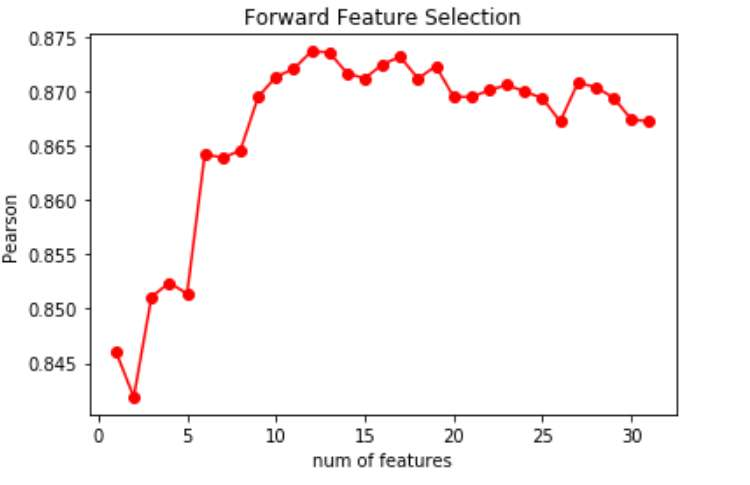
可以发现，有些特征的表现十分突出，如第七个特征，而在之前的特征相关性图中，第七个特征它与其他的特征的相关性很低，说明往往相关性很低的特征可以为系统的预测带来不错的贡献。但是对于一些会使pearsonr下降的特征我们仍保持怀疑态度，因为在最后的提交过程中，我们发现，所有特征都用上的时候，得分是最高的。所以说，在验证集上出现的下降现象并没有发生，反而是特征不足的情况下效果不佳。由于Sparse 特征维数过大，我们这里没有对其进行画图统计，但是最后的结果依然适用：加稀疏特征比不加好！

# 4.深度学习 方法

## 4.1模型简介
神经网络部分主要分为对文本本身的词向量进行训练和经过特征提取的简单网络结构组成。词向量部分使用glove.840B.300d作为预训练词向量信息，对于词向量库里没有的，重新基于文档进行训练。特征部分来自队友整理的18组特征，归一化以后进入网络训练。

对文本进行训练时选择3层cnn卷积网络来抓取文本特征，之后使用一个LSTM模型衔接，达到文本特有的文本序列的训练效果。实验中发现仅使用多层cnn pearson能够达到百分之70以上，加入LSTM能够达到百分之80以上。

单独使用特征进行网络学习效果不佳，最高pearson系数仅有63%，与文本网络融合以后影响也不是特别显著。最后深度学习网络最佳成绩仅有84%

语言晦涩，直接上图
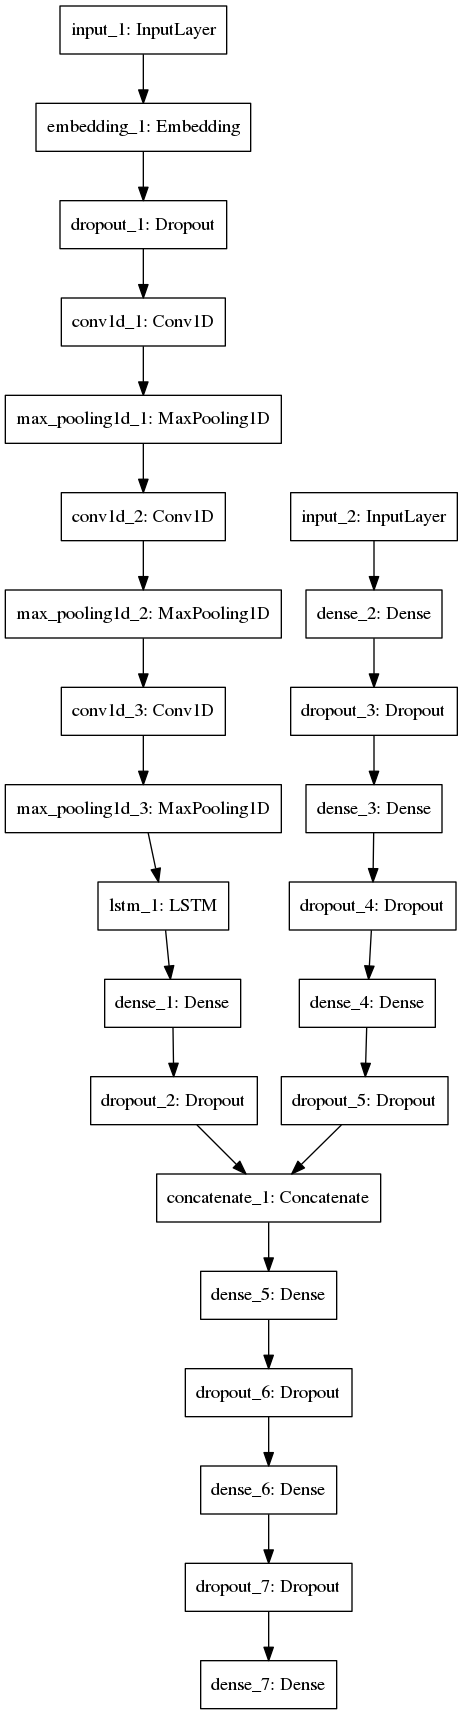

## 4.2实验结果
如图所示是神经网络训练loss值与其训练阶段的关系图。可以发现随着训练的时间加长，训练集的loss值在下降，而验证集的loss值已经出现趋于平稳状态。这表明模型是一个未完全拟合的模型，但是却感觉没有办法深入调整网络结构。
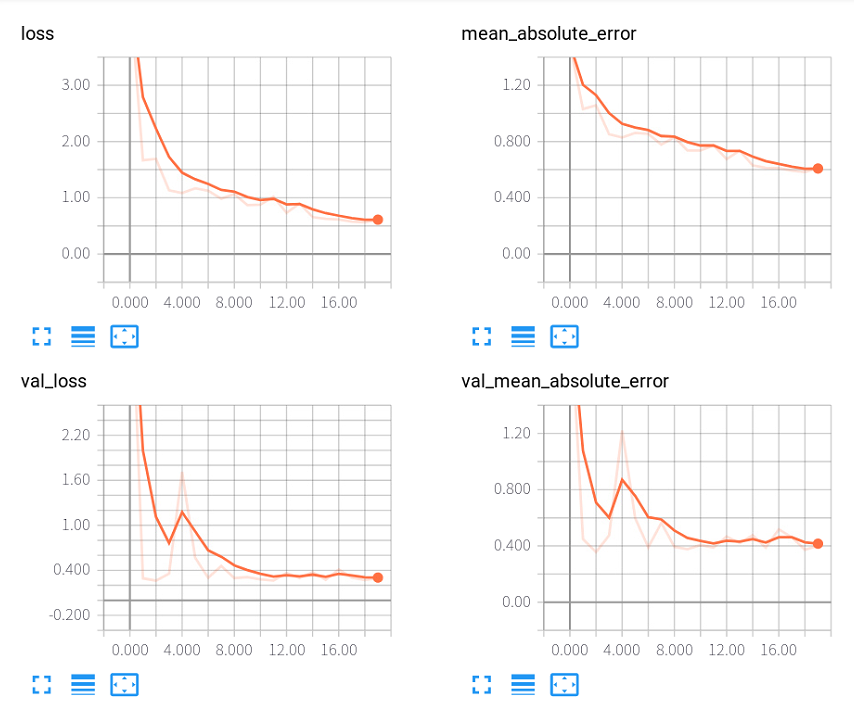
## 4.3 结果分析
深度学习方法由于训练量过小，并不能完全体现优势，虽然能够提取出文本特征，但发现文本特征并不适合与深度学习融合。学习结果中出现不应该出现的。如作文最低分有2分，但机器判断却只有0.38分。这是不符合范围的数据。也就是说，模型还不能较优的拟合所有状态。如果问题是分类问题，兴许会好些，但是没有时间实验了。

# 5 感想以及疑惑
## 5.1 问题：
1. 虽然画出了特征相关性，并且用了前向步进的方式测出了各个特征的关系和对结果的影响。但是去掉一些我们统计出来的“坏”特征后，并没有给系统的结果带来提升（指的是线上的test）。

## 5.2 不足
1. 没有用kflod，而是人为的for循环，很丑陋。
2. 代码有些冗余，导致特征提取过慢。